In [ ]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import numpy as np

# Устройство для вычислений
device = "cuda" if torch.cuda.is_available() else "cpu"

# Загружаем модель CLIP и процессор
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


# Загружаем CIFAR-10 (тестовый набор)
full_dataset = datasets.CIFAR10(root="./data", train=False, download=True)


def custom_collate(batch):
    images, labels = zip(*batch)
    return list(images), torch.tensor(labels)

subset_dataloader = DataLoader(full_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate)
# class_labels
# "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"

# Текстовые классы CIFAR-10
class_labels = full_dataset.classes

# Предварительно вычисляем текстовые эмбеддинги
text_inputs = processor(
    text=[f"A photo of a {label}" for label in class_labels],
    return_tensors="pt",
    padding=True
).to(device)

with torch.no_grad():
    text_features = model.get_text_features(**text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)  # Нормализация



Files already downloaded and verified


In [ ]:
!nvidia-smi

Tue Mar  4 13:55:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   73C    P0             31W /   70W |   14356MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

CLIP Accuracy on CIFAR-10 (10,000 samples): 88.80%


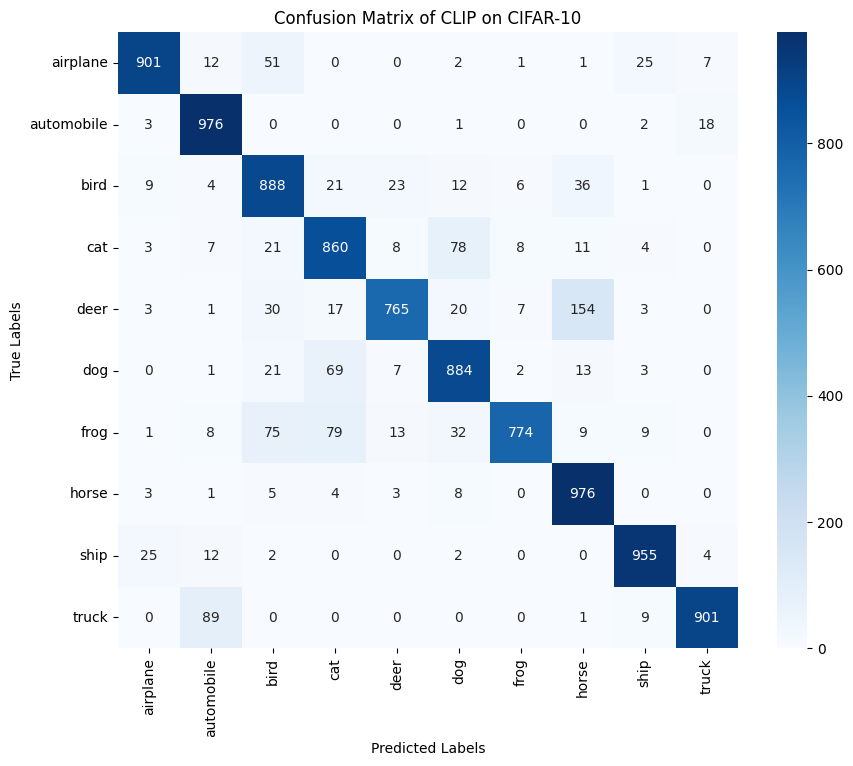

In [ ]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Функция оценки точности и анализа ошибок
def evaluate_clip_with_analysis(model, dataloader, device, class_labels):
    model.eval()
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            inputs = processor(images=images, return_tensors="pt", padding=True).to(device)

            image_features = model.get_image_features(**inputs)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            predictions = similarity.argmax(dim=-1)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.numpy())

            correct += (predictions.cpu() == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"CLIP Accuracy on CIFAR-10 (10,000 samples): {accuracy * 100:.2f}%")

    return np.array(all_preds), np.array(all_labels)


# Получаем предсказания модели
preds, labels = evaluate_clip_with_analysis(model, subset_dataloader, device, class_labels)

# Создаем матрицу ошибок
conf_matrix = confusion_matrix(labels, preds)

# Визуализация матрицы ошибок
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix of CLIP on CIFAR-10")
plt.show()

# Вычисляем точность по каждому классу
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Выводим точность по классам
for i, label in enumerate(class_labels):
    print(f"Accuracy for class '{label}': {class_accuracies[i] * 100:.2f}%")

# Находим классы с наибольшими ошибками
worst_classes = np.argsort(class_accuracies)[:3]
print("\nWorst performing classes:")
for i in worst_classes:
    print(f"Class '{class_labels[i]}' - Accuracy: {class_accuracies[i] * 100:.2f}%")


<ipython-input-56-5d16ec08c87b>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=errors_per_class, palette="Reds")


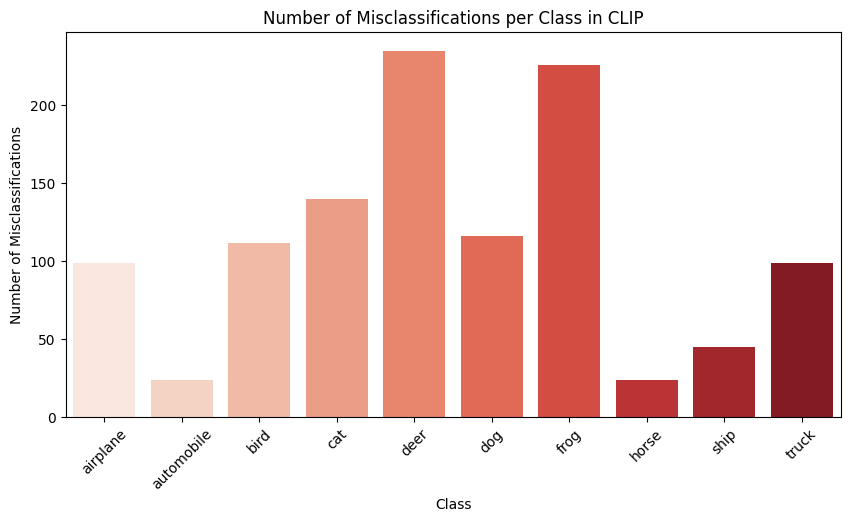

In [ ]:
# Количество ошибок по классам
errors_per_class = conf_matrix.sum(axis=1) - np.diag(conf_matrix)

# Визуализация
plt.figure(figsize=(10, 5))
sns.barplot(x=class_labels, y=errors_per_class, palette="Reds")
plt.xticks(rotation=45)
plt.xlabel("Class")
plt.ylabel("Number of Misclassifications")
plt.title("Number of Misclassifications per Class in CLIP")
plt.show()


<ipython-input-57-e86cb6140306>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=class_accuracies * 100, palette="Blues")


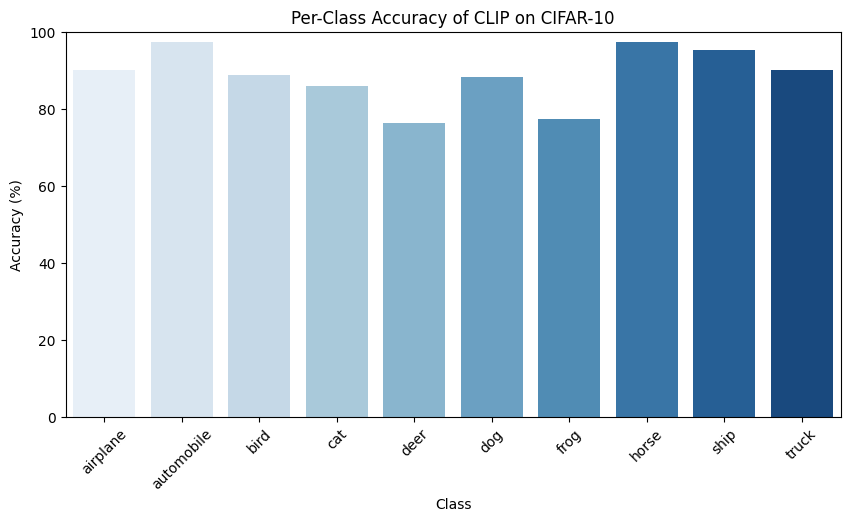

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x=class_labels, y=class_accuracies * 100, palette="Blues")
plt.xticks(rotation=45)
plt.xlabel("Class")
plt.ylabel("Accuracy (%)")
plt.title("Per-Class Accuracy of CLIP on CIFAR-10")
plt.ylim(0, 100)  # Ось Y от 0 до 100%
plt.show()


In [ ]:
# Матрица ошибок без диагонали (диагональ - это правильные предсказания)
conf_matrix_no_diag = conf_matrix.copy()
np.fill_diagonal(conf_matrix_no_diag, 0)

# Получаем 3 самых частых неверных предсказания
worst_mistakes = np.unravel_index(np.argsort(conf_matrix_no_diag.ravel())[-3:], conf_matrix_no_diag.shape)

# Выводим
print("\nMost common misclassifications:")
for true_label, pred_label in zip(*worst_mistakes):
    print(f"True: '{class_labels[true_label]}' → Predicted: '{class_labels[pred_label]}' ({conf_matrix[true_label, pred_label]} times)")



Most common misclassifications:
True: 'frog' → Predicted: 'cat' (79 times)
True: 'truck' → Predicted: 'automobile' (89 times)
True: 'deer' → Predicted: 'horse' (154 times)


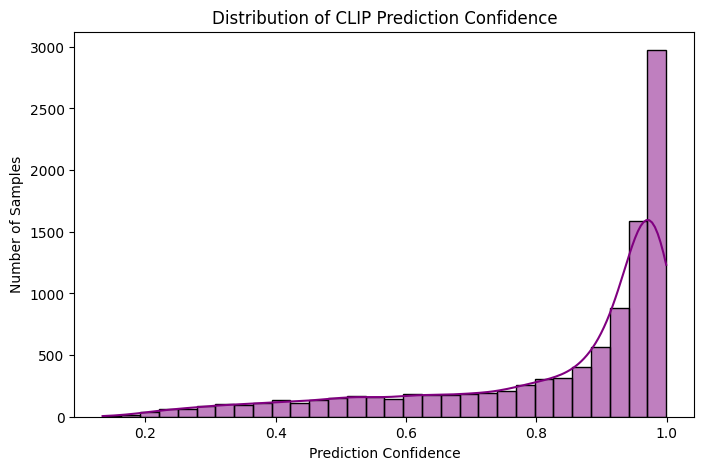

In [ ]:
# Сохраняем все вероятности предсказаний
all_confidences = []

with torch.no_grad():
    for images, labels in subset_dataloader:
        inputs = processor(images=images, return_tensors="pt", padding=True).to(device)
        image_features = model.get_image_features(**inputs)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        top_confidences, _ = similarity.max(dim=-1)  # Берем вероятность топ-1 предсказания

        all_confidences.extend(top_confidences.cpu().numpy())

# Визуализация распределения уверенности модели
plt.figure(figsize=(8, 5))
sns.histplot(all_confidences, bins=30, kde=True, color="purple")
plt.xlabel("Prediction Confidence")
plt.ylabel("Number of Samples")
plt.title("Distribution of CLIP Prediction Confidence")
plt.show()
